# Final Project INF-475
## Wildfire Spreading: Weather forecasting
### Daniel San Martín

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot

In [21]:
FtoC = lambda t: (t - 32) * (5 / 9)

In [22]:
df = pd.read_csv('data/CDO5622797695969.csv') # Read data
df.rename(columns=lambda i: i.strip(), inplace=True) # Clean white spaces in header
df.head() # Show some values

,STN---,WBAN,YEARMODA,TEMP,,DEWP,.1,SLP,.2,STP,...,WDSP,.5,MXSPD,GUST,MAX,MIN,PRCP,SNDP,FRSHTT,Unnamed: 22
0,859212,99999,20091031,57.7,7,52.8,7,9999.9,0,9999.9,...,23.1,7,999.9,999.9,59.0*,55.4*,0.00I,999.9,100000,NaN
1,859212,99999,20091101,58.1,8,52.7,8,9999.9,0,9999.9,...,4.7,8,8.0,999.9,60.8*,55.4*,0.00I,999.9,0,NaN
2,859212,99999,20091106,64.4,4,44.6,4,9999.9,0,9999.9,...,14.0,4,15.9,999.9,66.2*,62.6*,0.00I,999.9,0,NaN
3,859212,99999,20091107,55.0,5,43.2,5,9999.9,0,9999.9,...,7.6,5,14.0,999.9,62.6*,51.8*,0.00I,999.9,0,NaN
4,859212,99999,20091108,58.2,7,47.2,7,9999.9,0,9999.9,...,8.4,7,15.0,999.9,66.2*,51.8*,0.00I,999.9,0,NaN


In [104]:
df.describe()

,STN---,WBAN,YEARMODA,TEMP,,DEWP,.1,SLP,.2,STP,.3,VISIB,.4,WDSP,.5,MXSPD,GUST,SNDP,FRSHTT,Unnamed: 22
count,2126.0,2126.0,2.126000e+03,2126.000000,2126.000000,2126.000000,2126.000000,2.126000e+03,2126.0,2.126000e+03,2126.0,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2.126000e+03,2126.000000,0.0
mean,859212.0,99999.0,2.013885e+07,57.099718,22.209313,50.595390,22.195673,9.999900e+03,0.0,9.999900e+03,0.0,157.359548,15.719191,5.504798,22.127940,16.388993,982.992239,9.999000e+02,19901.241769,NaN
std,0.0,0.0,2.998035e+04,5.458795,2.862977,4.814197,2.869605,1.073456e-10,0.0,1.073456e-10,0.0,357.997705,8.385684,37.430917,3.025165,74.198387,127.076389,3.900376e-11,39431.717691,NaN
min,859212.0,99999.0,2.009103e+07,42.000000,4.000000,29.700000,4.000000,9.999900e+03,0.0,9.999900e+03,0.0,0.100000,0.000000,0.000000,0.000000,2.900000,20.000000,9.999000e+02,0.000000,NaN
25%,859212.0,99999.0,2.011050e+07,53.100000,21.000000,47.400000,21.000000,9.999900e+03,0.0,9.999900e+03,0.0,5.000000,10.000000,3.000000,21.000000,8.900000,999.900000,9.999000e+02,0.000000,NaN
50%,859212.0,99999.0,2.015081e+07,56.900000,23.000000,50.700000,23.000000,9.999900e+03,0.0,9.999900e+03,0.0,6.100000,19.000000,3.900000,23.000000,9.900000,999.900000,9.999000e+02,0.000000,NaN
75%,859212.0,99999.0,2.017012e+07,61.100000,24.000000,54.200000,24.000000,9.999900e+03,0.0,9.999900e+03,0.0,6.300000,22.000000,5.000000,24.000000,13.000000,999.900000,9.999000e+02,10000.000000,NaN
max,859212.0,99999.0,2.018073e+07,76.900000,24.000000,64.700000,24.000000,9.999900e+03,0.0,9.999900e+03,0.0,999.900000,24.000000,999.900000,24.000000,999.900000,999.900000,9.999000e+02,110000.000000,NaN


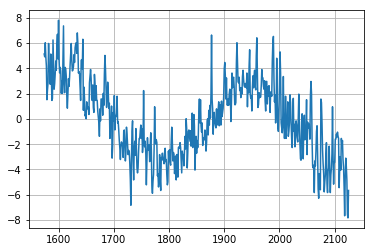

In [110]:
d_17_18 = df.loc[int(df.index[df['YEARMODA'] == 20170101][0]):] # Get data since 2017
d_c = FtoC(d_17_18['TEMP']) # Transform to celsius
y_t = d_c - d_c.mean() # Center data
y_t.plot()
plt.grid(True)
plt.show()

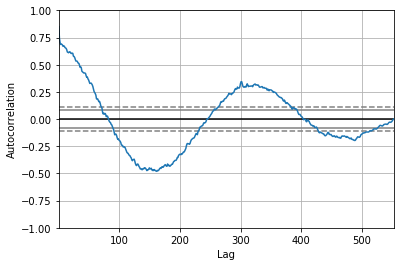

In [111]:
pd.plotting.autocorrelation_plot(y_t)
plt.show()

/home/dsanmartin/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


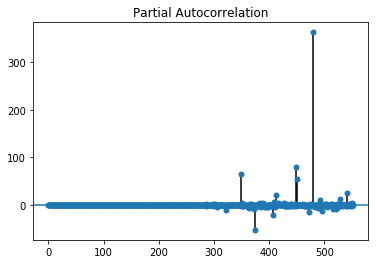

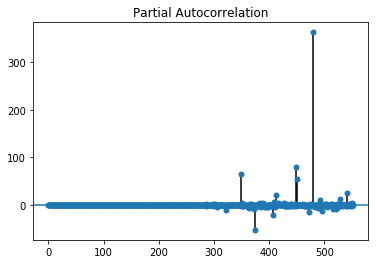

In [113]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y_t)

In [114]:
from statsmodels.tsa.arima_model import ARIMA

In [118]:
model = ARIMA(y_t, order=(2, 1, 2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.TEMP   No. Observations:                  551
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -980.806
Method:                       css-mle   S.D. of innovations              1.434
Date:                Sat, 28 Jul 2018   AIC                           1973.611
Time:                        19:04:57   BIC                           1999.482
Sample:                             1   HQIC                          1983.720
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0166      0.011     -1.502      0.134      -0.038       0.005
ar.L1.D.TEMP    -0.0680      0.303     -0.225      0.822      -0.662       0.526
ar.L2.D.TEMP     0.1525      0.180      0.84

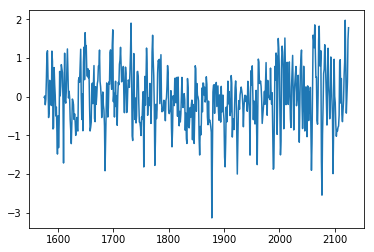

In [123]:
model_fit.fittedvalues.plot()

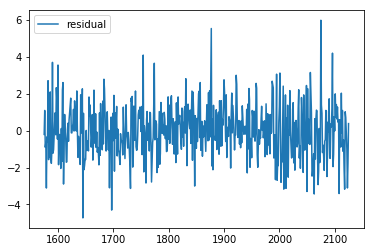

In [124]:
residuals = pd.DataFrame(model_fit.resid, columns=['residual'])
residuals.plot()
plt.legend()
plt.show()

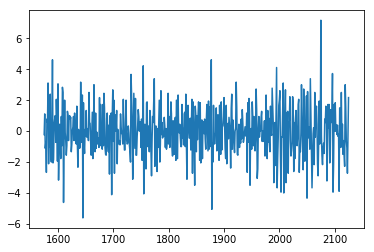

In [125]:
plt.plot(model_fit.resid + model_fit.fittedvalues)
plt.show()

In [126]:
model_fit.plot_diagnostics(figsize=(20, 14))
plt.show()

AttributeError: 'ARIMAResults' object has no attribute 'plot_diagnostics'